In [1]:
import numpy as np
from torchvision.models import resnet18
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch

import pandas

import os
import glob
from google.colab import drive
from torch.utils.data import Dataset

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings
# Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

drive.mount('/content/drive')

root = "drive/MyDrive/641/"
import sys
from torchvision import models
import torchvision.models.quantization as quant_models


Mounted at /content/drive


In [2]:
os.system("unzip EE641.zip")

256

In [3]:
from nnet import *

model_filename = "./models/TinyTaxiNet.nnet"
network = NNet(model_filename)



In [2]:
class TaxiNetDNN(nn.Module):
    def __init__(self, model_name="resnet18", quantize=False):
        super(TaxiNetDNN, self).__init__()
        if model_name == 'resnet18':
            self.model = models.resnet18(pretrained=True)
        elif model_name == 'resnet34':
            self.model = models.resnet34(pretrained=True)
        elif model_name == 'squeezenet':
            self.model = models.squeezenet1_1(pretrained=True)

        if quantize:
            self.model = quant_models.resnet18(pretrained=True, quantize=True)

        y_dim = 2
        self.model.fc = nn.Linear(self.model.fc.in_features, y_dim)
        self.fc = self.model.fc

    def forward(self, z):
        out = self.model(z)
        return out

def QuantTaxiNetDNN():
    # You will need the number of filters in the `fc` for future use.
    # Here the size of each output sample is set to 2.
    # Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
    model_fe = quant_models.resnet18(pretrained=True, progress=True, quantize=True)
    num_ftrs = model_fe.fc.in_features

    # Step 1. Isolate the feature extractor.
    model_fe_features = nn.Sequential(
    model_fe.quant,  # Quantize the input
    model_fe.conv1,
    model_fe.bn1,
    model_fe.relu,
    model_fe.maxpool,
    model_fe.layer1,
    model_fe.layer2,
    model_fe.layer3,
    model_fe.layer4,
    model_fe.avgpool,
    model_fe.dequant,  # Dequantize the output
    )

    # Step 2. Create a new "head"
    new_head = nn.Sequential(
    nn.Linear(num_ftrs, 2),
    )

    # Step 3. Combine, and don't forget the quant stubs.
    new_model = nn.Sequential(
    model_fe_features,
    nn.Flatten(1),
    new_head,
    )
    
    return new_model



def freeze_model(model, freeze_frac=True):
    # freeze everything
    n_params = len(list(model.parameters()))
    for i, p in enumerate(model.parameters()):
        #if i < 6*n_params/7:
        if i < 4*n_params/7:
            p.requires_grad = False

    # make last layer trainable
    for p in model.fc.parameters():
        p.requires_grad = True
       
    return model


def unfreeze_model(model):
    global og_req_grads
    # unfreeze everything
    for p,v in zip( model.parameters(), og_req_grads):
        p.requires_grad = v

In [3]:
model = TaxiNetDNN()
# checkpoint = torch.load("best_model.pt")
# model.load_state_dict(checkpoint)
model = model.cuda()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 224MB/s]


In [14]:
os.system("unzip drive/MyDrive/641/EE641_final_project/morning.zip")

0

Generator

In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1), # Pads the input tensor using the reflection of the input boundary
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features), 
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features)
        )

    def forward(self, x):
        return x + self.block(x)


class GeneratorResNet(nn.Module):
    def __init__(self, input_shape, num_residual_block):
        super(GeneratorResNet, self).__init__()
        
        channels = input_shape[0]
        
        # Initial Convolution Block
        out_features = 64
        model = [
            nn.ReflectionPad2d(channels),
            nn.Conv2d(channels, out_features, 7),
            nn.InstanceNorm2d(out_features),
            nn.ReLU(inplace=True)
        ]
        in_features = out_features
        
        # Downsampling
        for _ in range(2):
            out_features *= 2
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
        
        # Residual blocks
        for _ in range(num_residual_block):
            model += [ResidualBlock(out_features)]
            
        # Upsampling
        for _ in range(2):
            out_features //= 2
            model += [
                nn.Upsample(scale_factor=2), # --> width*2, heigh*2
                nn.Conv2d(in_features, out_features, 3, stride=1, padding=1),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            
        # Output Layer
        model += [nn.ReflectionPad2d(channels),
                  nn.Conv2d(out_features, channels, 7),
                  nn.Tanh()
                 ]
        
        # Unpacking
        self.model = nn.Sequential(*model) 
        
    def forward(self, x):
        return self.model(x)

Discrimator


Losses

In [5]:
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

Models/optimizers

In [6]:

# data (img)
img_height = 256
img_width = 256
channels = 3

n_cpu = 2 # number of cpu threads to use during batch generation

# training
epoch = 0 # epoch to start training from
n_epochs = 5 # number of epochs of training
batch_size = 1 # size of the batches
lr = 0.0002 # adam : learning rate
b1 = 0.5 # adam : decay of first order momentum of gradient
b2 = 0.999 # adam : decay of first order momentum of gradient
decay_epoch = 3 # suggested default : 100 (suggested 'n_epochs' is 200)
                 # epoch from which to start lr decay


In [7]:
input_shape = (channels, img_height, img_width) # (3,256,256)
n_residual_blocks = 9 # suggested default, number of residual blocks in generator

G_AB = GeneratorResNet(input_shape, n_residual_blocks)
G_BA = GeneratorResNet(input_shape, n_residual_blocks)

cuda = torch.cuda.is_available()

if cuda:
    G_AB = G_AB.cuda()
    G_BA = G_BA.cuda()
    
    criterion_GAN.cuda()
    criterion_cycle.cuda()
    criterion_identity.cuda()

In [8]:
import itertools
# lr = 0.0002
# b1 = 0.5
# b2 = 0.999

optimizer_G = torch.optim.Adam(
    itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=lr, betas=(b1,b2)
)

optimizer_Taxi = torch.optim.Adam(
    itertools.chain(model.parameters()), lr=lr, betas=(b1,b2)
)


DATA

In [9]:
from PIL import Image
import torchvision.transforms as transforms

transforms_ = [
    transforms.Resize(int(img_height*1.12), Image.BICUBIC),
    transforms.RandomCrop((img_height, img_width)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]

In [10]:
class LambdaLR:
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert (n_epochs - decay_start_epoch) > 0, "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch
        
    def step(self, epoch):
        return 1.0 - max(0, epoch+self.offset - self.decay_start_epoch)/(self.n_epochs - self.decay_start_epoch)

# n_epochs = 10
# epoch = 0
# decay_epoch = 5


lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(
    optimizer_G,
    lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step
)

lr_scheduler_Taxi = torch.optim.lr_scheduler.LambdaLR(
    optimizer_Taxi,
    lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step
)



In [11]:
class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, unaligned=False, mode='train'):
        self.transform = transforms.Compose(transforms_)
        self.unaligned = unaligned
        self.mode = mode
        self.label_file = root + '/labels.csv'
        self.labels_df = pandas.read_csv(label_file, sep=',')
     
        # dataframe of labels
        self.labels_df = pandas.read_csv(label_file, sep=',')
        
        if self.mode == 'train':
            self.files_A = sorted(glob.glob(os.path.join(root+'/morning_train')+'/*.*'))
        elif self.mode == 'test':
            self.files_A = sorted(glob.glob(os.path.join(root+'/morning_test')+'/*.*'))

    def  __getitem__(self, index):
        image_A = Image.open(self.files_A[index % len(self.files_A)])
        item_A = self.transform(image_A)
        
        
        return 
    
    def __len__(self):
        return max(len(self.files_A), len(self.files_B))
            

In [12]:
class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, unaligned=False, mode='train'):
        'Initialization'
        # image data path and time series data loading
        self.data_dir = "morning/morning_train"

        self.image_list = [x for x in os.listdir(self.data_dir) if x.endswith('.png')]

        # where the labels for each image (such as distance to centerline) are present
        label_file = self.data_dir + '/labels.csv'
     
        # dataframe of labels
        self.labels_df = pandas.read_csv(label_file, sep=',')
        IMAGE_WIDTH  = 224
        IMAGE_HEIGHT = 224
        # image transforms
        self.tfms = transforms.Compose([transforms.Resize((IMAGE_WIDTH, IMAGE_HEIGHT)),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406],
                                                             [0.229, 0.224, 0.225]),])

    def  __getitem__(self, index):
        'Generates one sample of data'

        image_name = self.image_list[index]

        # open images and apply transforms
        fname = self.data_dir + '/' + str(image_name)
        image = Image.open(fname).convert('RGB')
        tensor_image_example = self.tfms(image)

        # get the corresponding state information (labels) for each image
        specific_row = self.labels_df[self.labels_df['image_filename'] == image_name]
        # there are many states of interest, you can modify to access which ones you want
        dist_centerline_norm = specific_row['distance_to_centerline_NORMALIZED'].item()
        # normalized downtrack position
        downtrack_position_norm = specific_row['downtrack_position_NORMALIZED'].item()

        # add tensor
        target_tensor_list = [dist_centerline_norm, downtrack_position_norm]

        # concatenate all image tensors
        target_tensor = torch.tensor(target_tensor_list)
    
        return tensor_image_example, target_tensor
    
    def __len__(self):
        # number of images in dataset
        num_images = len(self.image_list)
        return num_images


In [15]:
dataloader = DataLoader(
    ImageDataset(root, unaligned=True),
    batch_size=20, # 1
    shuffle=True,
    num_workers=n_cpu # 3
)

val_dataloader = DataLoader(
    ImageDataset(root, unaligned=True, mode='test'),
    batch_size=5,
    shuffle=True,
    num_workers=n_cpu
)

Training

In [16]:
def sample_images():
    """show a generated sample from the test set"""
    data = next(iter(val_dataloader))
    img, l = data
    model.eval()
    
    img = img.cuda()
    print(model(img))
    G_AB.eval()
    G_BA.eval()
    real_A = img
    fake_B = G_AB(real_A).detach()
    fake_A = G_BA(fake_B).detach()
    print(model(fake_B))
    print(l)
    # fake_B_grey_scale = transforms.Grayscale()(real_A)
    # fake_A_grey_scale = transforms.Grayscale()(fake_B)

    # Arange images along x-axis
    real_A = make_grid(real_A, nrow=5, normalize=True)
    fake_B = make_grid(fake_B, nrow=5, normalize=True)
    fake_A = make_grid(fake_A, nrow=5, normalize=True)

    # real_A_grey = make_grid(fake_B_grey_scale, nrow=5, normalize=True)
    # fake_B_grey = make_grid(fake_A_grey_scale, nrow=5, normalize=True)
    # Arange images along y-axis    
    image_grid = torch.cat((real_A, fake_B, fake_A), 1)
    plt.imshow(image_grid.cpu().permute(1,2,0))
    plt.title('Real vs AB vs BA')
    plt.axis('off')
    plt.show();

tensor([[ 0.9961, -0.8813],
        [ 0.9307, -0.8953],
        [ 1.0089, -0.8347],
        [ 1.2722, -1.0861],
        [ 0.7465, -0.7175]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[ 0.7873, -0.4923],
        [ 0.8330, -0.5692],
        [ 0.7895, -0.6222],
        [ 0.6203, -0.7429],
        [ 0.6731, -0.4680]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.6044,  0.0537],
        [-0.1850,  0.3527],
        [ 0.9031,  0.6189],
        [-0.4353,  0.5252],
        [-0.4523,  0.3446]])


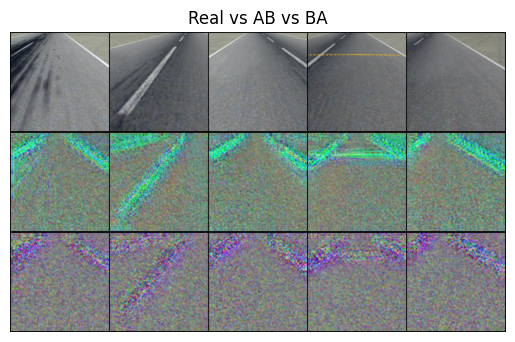

In [17]:
sample_images()

  0%|          | 0/2240 [00:00<?, ?it/s]

<ipython-input-18-48eae2fea9b7>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bad_pred = torch.tensor(bad_pred)


TaxiNetLoss0.12376002341508865
[Epoch 1/5] [Batch 50/2240] [G loss : 2.556630 - (adv : -0.123760, cycle : 0.249908, identity : 0.259031)]
TaxiNetLoss0.04872805614024401
[Epoch 1/5] [Batch 100/2240] [G loss : 2.590284 - (adv : -0.048728, cycle : 0.201206, identity : 0.213102)]
TaxiNetLoss0.03996500540524721
[Epoch 1/5] [Batch 150/2240] [G loss : 2.439104 - (adv : -0.039965, cycle : 0.186824, identity : 0.194103)]
tensor([[ 0.6445,  0.6844],
        [-0.3540,  0.8245],
        [ 0.6203,  0.6479],
        [ 0.2671,  0.0593],
        [-0.0585,  0.3875]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.1177,  0.4546],
        [-0.1754,  0.5026],
        [-0.2312,  0.3941],
        [-0.1975,  0.3703],
        [-0.1876,  0.4668]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[ 0.6430,  0.8915],
        [-0.2570,  0.8982],
        [ 0.6158,  0.4006],
        [ 0.3942,  0.0545],
        [ 0.0189,  0.2469]])


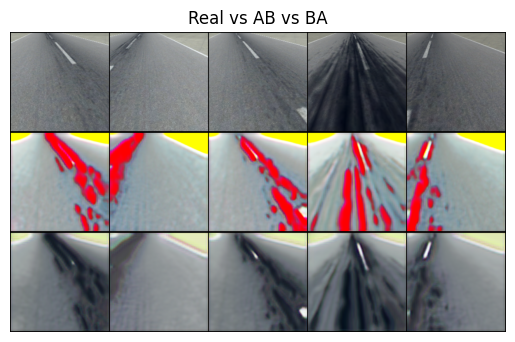

TaxiNetLoss0.037915909327566624
[Epoch 1/5] [Batch 200/2240] [G loss : 2.348389 - (adv : -0.037916, cycle : 0.180101, identity : 0.185308)]
TaxiNetLoss0.03761315856128931
[Epoch 1/5] [Batch 250/2240] [G loss : 2.267066 - (adv : -0.037613, cycle : 0.174971, identity : 0.178698)]
TaxiNetLoss0.03180476412177086
[Epoch 1/5] [Batch 300/2240] [G loss : 2.242524 - (adv : -0.031805, cycle : 0.170163, identity : 0.171789)]
TaxiNetLoss0.03192285479977727
[Epoch 1/5] [Batch 350/2240] [G loss : 2.164686 - (adv : -0.031923, cycle : 0.164184, identity : 0.168415)]
tensor([[-0.3513,  0.4919],
        [ 0.2866,  0.3836],
        [ 0.2693,  0.5204],
        [ 0.6920, -0.3593],
        [ 0.4709,  0.4035]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.2386,  0.4965],
        [-0.0338,  0.4667],
        [-0.0101,  0.5939],
        [-0.0041,  0.2117],
        [ 0.0894,  0.2731]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.3626,  0.1464],
        [ 0.3228,  0.1611],
        [ 0.2211,  

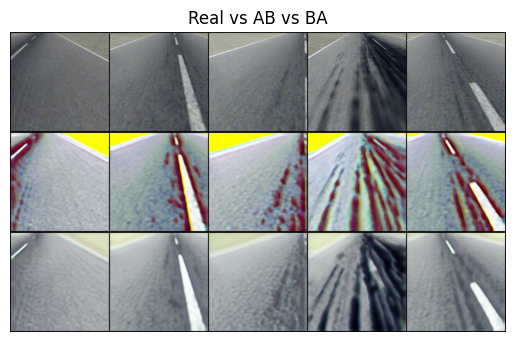

TaxiNetLoss0.029228963945060967
[Epoch 1/5] [Batch 400/2240] [G loss : 2.163160 - (adv : -0.029229, cycle : 0.162648, identity : 0.165793)]
TaxiNetLoss0.029516382068395616
[Epoch 1/5] [Batch 450/2240] [G loss : 2.160512 - (adv : -0.029516, cycle : 0.162268, identity : 0.166598)]
TaxiNetLoss0.029267976097762584
[Epoch 1/5] [Batch 500/2240] [G loss : 2.286711 - (adv : -0.029268, cycle : 0.171923, identity : 0.172031)]
TaxiNetLoss0.028013123832643032
[Epoch 1/5] [Batch 550/2240] [G loss : 2.286421 - (adv : -0.028013, cycle : 0.169700, identity : 0.173911)]
tensor([[ 0.7100,  0.3189],
        [ 0.5878,  0.5976],
        [ 0.2555,  0.7044],
        [-0.1073,  0.1120],
        [-0.2923,  0.4986]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.1905,  0.1510],
        [ 0.0546,  0.3280],
        [-0.1629,  0.3340],
        [-0.2930,  0.2399],
        [-0.2065,  0.4221]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[ 0.7560,  0.4399],
        [ 0.5101,  0.5972],
        [ 0.1878

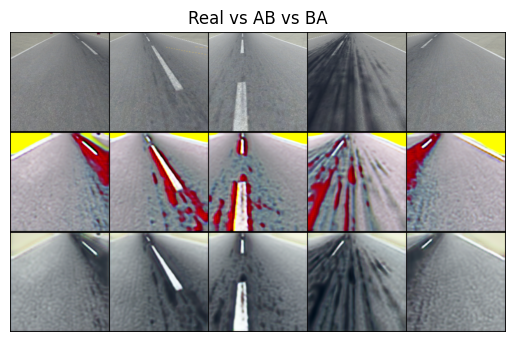

TaxiNetLoss0.028982655946165323
[Epoch 1/5] [Batch 600/2240] [G loss : 2.238711 - (adv : -0.028983, cycle : 0.168442, identity : 0.168823)]
TaxiNetLoss0.02765095803886652
[Epoch 1/5] [Batch 650/2240] [G loss : 2.197733 - (adv : -0.027651, cycle : 0.165312, identity : 0.164224)]
TaxiNetLoss0.02690116871148348
[Epoch 1/5] [Batch 700/2240] [G loss : 2.103826 - (adv : -0.026901, cycle : 0.158107, identity : 0.158353)]
TaxiNetLoss0.026210809666663407
[Epoch 1/5] [Batch 750/2240] [G loss : 1.991209 - (adv : -0.026211, cycle : 0.149260, identity : 0.152144)]
tensor([[-0.9261,  0.4044],
        [-0.3474,  0.6369],
        [ 0.0539,  0.7890],
        [-0.0961,  0.3763],
        [ 0.4731,  0.4647]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.2072,  0.6494],
        [-0.2052,  0.3822],
        [-0.0169,  0.2477],
        [-0.1132,  0.2636],
        [ 0.0245,  0.5994]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.9171,  0.3353],
        [-0.3619,  0.7686],
        [-0.0258, 

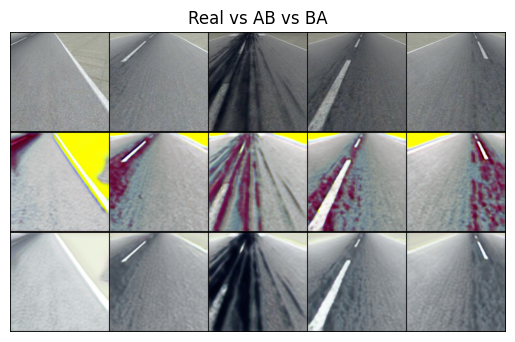

TaxiNetLoss0.024788235891610385
[Epoch 1/5] [Batch 800/2240] [G loss : 1.987091 - (adv : -0.024788, cycle : 0.148084, identity : 0.150828)]
TaxiNetLoss0.02451188590377569
[Epoch 1/5] [Batch 850/2240] [G loss : 1.949122 - (adv : -0.024512, cycle : 0.145003, identity : 0.148842)]
TaxiNetLoss0.026480260752141476
[Epoch 1/5] [Batch 900/2240] [G loss : 1.908361 - (adv : -0.026480, cycle : 0.143857, identity : 0.146918)]
TaxiNetLoss0.027010416090488435
[Epoch 1/5] [Batch 950/2240] [G loss : 1.864062 - (adv : -0.027010, cycle : 0.141516, identity : 0.143801)]
tensor([[-0.5018,  0.4279],
        [ 0.8770,  0.4928],
        [-0.1320,  0.0974],
        [-0.3875,  0.2601],
        [-0.6765,  0.5389]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.2715,  0.2949],
        [ 0.4364,  0.3833],
        [-0.0673,  0.2911],
        [-0.2003,  0.3371],
        [-0.2097,  0.4323]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.5449,  0.7637],
        [ 0.8005,  0.5682],
        [-0.1554,

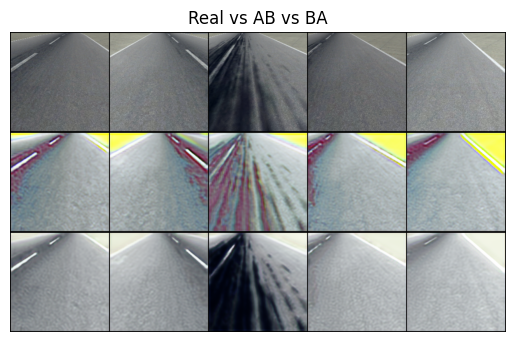

TaxiNetLoss0.02442640945315361
[Epoch 1/5] [Batch 1000/2240] [G loss : 1.931159 - (adv : -0.024426, cycle : 0.144158, identity : 0.146768)]
TaxiNetLoss0.02580304993316531
[Epoch 1/5] [Batch 1050/2240] [G loss : 1.885456 - (adv : -0.025803, cycle : 0.141982, identity : 0.144733)]
TaxiNetLoss0.02506207698956132
[Epoch 1/5] [Batch 1100/2240] [G loss : 1.869010 - (adv : -0.025062, cycle : 0.140446, identity : 0.143034)]
TaxiNetLoss0.024006507825106382
[Epoch 1/5] [Batch 1150/2240] [G loss : 1.878528 - (adv : -0.024007, cycle : 0.140657, identity : 0.142404)]
tensor([[-0.7234,  0.6283],
        [ 0.7878,  0.5266],
        [ 0.7047,  0.1420],
        [ 0.5115,  0.5518],
        [ 0.1670,  0.9957]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.2561,  0.4913],
        [ 0.4428,  0.3267],
        [ 0.1928,  0.1228],
        [ 0.2983,  0.1738],
        [ 0.0397,  0.1652]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.6828,  0.7593],
        [ 0.7831,  0.7951],
        [ 0.725

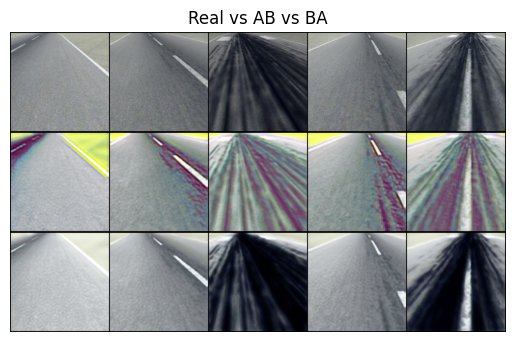

TaxiNetLoss0.021405056323856114
[Epoch 1/5] [Batch 1200/2240] [G loss : 1.909392 - (adv : -0.021405, cycle : 0.140500, identity : 0.143688)]
TaxiNetLoss0.024377379324287175
[Epoch 1/5] [Batch 1250/2240] [G loss : 2.004040 - (adv : -0.024377, cycle : 0.149867, identity : 0.149829)]
TaxiNetLoss0.024659697897732258
[Epoch 1/5] [Batch 1300/2240] [G loss : 1.848276 - (adv : -0.024660, cycle : 0.138689, identity : 0.141597)]
TaxiNetLoss0.023562540989369152
[Epoch 1/5] [Batch 1350/2240] [G loss : 1.821003 - (adv : -0.023563, cycle : 0.136196, identity : 0.138933)]
tensor([[ 0.0284,  0.4731],
        [-0.0653,  0.3070],
        [ 0.3094,  0.6438],
        [-0.0069,  0.4031],
        [-0.3272,  0.5572]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-3.0203e-02,  3.9967e-01],
        [ 1.2993e-04,  4.3572e-01],
        [ 2.3688e-01,  3.3300e-01],
        [-3.9486e-02,  4.1148e-01],
        [-1.3659e-01,  3.9979e-01]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[ 0.0553,  0.2488],


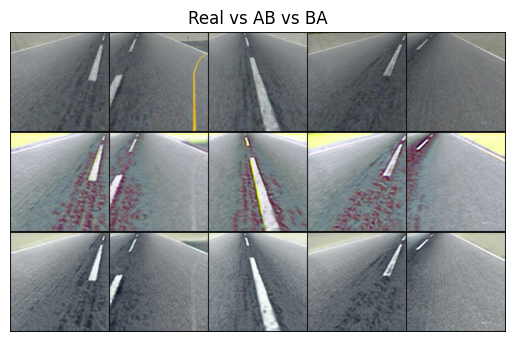

TaxiNetLoss0.023077250458300114
[Epoch 1/5] [Batch 1400/2240] [G loss : 1.811755 - (adv : -0.023077, cycle : 0.135236, identity : 0.138033)]
TaxiNetLoss0.02351314602419734
[Epoch 1/5] [Batch 1450/2240] [G loss : 1.815409 - (adv : -0.023513, cycle : 0.136027, identity : 0.138055)]
TaxiNetLoss0.021369895935058593
[Epoch 1/5] [Batch 1500/2240] [G loss : 1.832292 - (adv : -0.021370, cycle : 0.135394, identity : 0.138410)]
TaxiNetLoss0.023984880037605762
[Epoch 1/5] [Batch 1550/2240] [G loss : 1.857339 - (adv : -0.023985, cycle : 0.138882, identity : 0.141674)]
tensor([[-0.3476,  0.4525],
        [ 0.2457,  0.5581],
        [-0.3109,  0.4284],
        [-0.3148,  0.5852],
        [-0.1000,  0.5577]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.0927,  0.3373],
        [ 0.0805,  0.3667],
        [-0.1357,  0.1455],
        [-0.2124,  0.4251],
        [-0.0354,  0.2420]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.3574,  0.6865],
        [ 0.2167,  0.5752],
        [-0.3

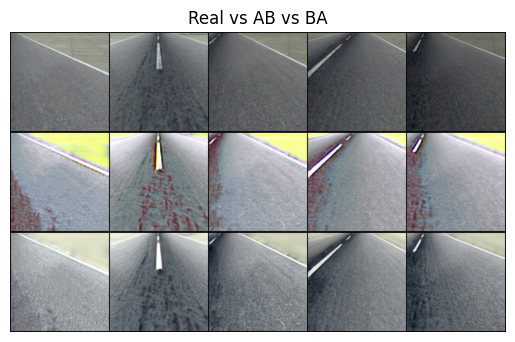

TaxiNetLoss0.022429424040019512
[Epoch 1/5] [Batch 1600/2240] [G loss : 1.836061 - (adv : -0.022429, cycle : 0.136437, identity : 0.139197)]
TaxiNetLoss0.02198566051200032
[Epoch 1/5] [Batch 1650/2240] [G loss : 1.822480 - (adv : -0.021986, cycle : 0.135462, identity : 0.137542)]
TaxiNetLoss0.02236349679529667
[Epoch 1/5] [Batch 1700/2240] [G loss : 1.734868 - (adv : -0.022363, cycle : 0.129924, identity : 0.131852)]
TaxiNetLoss0.021895506735891104
[Epoch 1/5] [Batch 1750/2240] [G loss : 1.836442 - (adv : -0.021896, cycle : 0.136078, identity : 0.138923)]
tensor([[ 0.4272,  0.4277],
        [-0.4078,  1.0809],
        [ 0.3377, -0.0244],
        [ 0.4203,  0.4414],
        [-0.3046,  0.0689]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[ 0.2787,  0.2944],
        [-0.3208,  0.3537],
        [ 0.0470,  0.1305],
        [ 0.3130,  0.2965],
        [-0.2035,  0.1163]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[ 0.4783,  0.3833],
        [-0.3634,  0.9025],
        [ 0.34

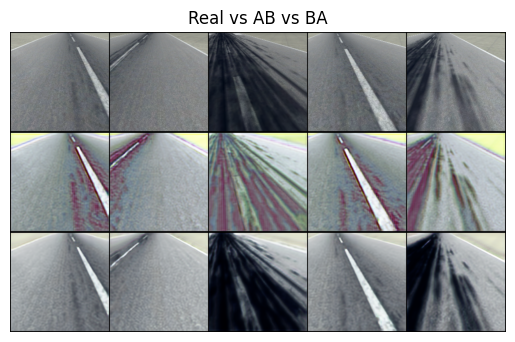

TaxiNetLoss0.021489163404330613
[Epoch 1/5] [Batch 1800/2240] [G loss : 1.851971 - (adv : -0.021489, cycle : 0.136986, identity : 0.139400)]
TaxiNetLoss0.01984913358464837
[Epoch 1/5] [Batch 1850/2240] [G loss : 1.905269 - (adv : -0.019849, cycle : 0.139994, identity : 0.140764)]


KeyboardInterrupt: ignored

In [18]:
loss_Gan_avg = 0
loss_G_avg   = 0
loss_cy_avg  = 0
loss_id_avg  = 0
Taxi_avg     = 0
for epoch in range(epoch, n_epochs):
    for i, batch in enumerate(tqdm(dataloader)):
        # Set model input
        image_batch, labels = batch
        image_batch = image_batch.cuda()
        labels = labels.cuda()
# -----------------
# Train Generators
# -----------------
        G_AB.train() # train mode
        G_BA.train() # train mode
        model.train()

        optimizer_G.zero_grad() # Integrated optimizer(G_AB, G_BA)
        optimizer_Taxi.zero_grad()
        
        # Identity Loss
        loss_id_A = criterion_identity(G_BA(image_batch), image_batch) # If you put A into a generator that creates A with B,                                                
        loss_identity = loss_id_A
        loss_id_A_2 = criterion_identity(G_AB(image_batch), image_batch) # If you put A into a generator that creates A with B,                                                
        loss_identity = loss_id_A*.9 + loss_id_A_2*.1
        # print(image_batch[0].size())
        # GAN Loss
        bad_images = G_AB(image_batch) # fake_B is fake-photo that generated by real monet-drawing
        # flatten_image_batch = torch.flatten(image_batch[0])
        bad_pred = model(image_batch) #network.evaluate_network(flatten_image_batch)
        # print(bad_pred)
        bad_pred = torch.tensor(bad_pred)
        bad_pred = bad_pred.cuda()
        # print(labels)
        loss_GAN_AB = criterion_GAN(bad_pred, labels) # tricking the 'fake-B' into 'real-B'
        
        loss_GAN = -loss_GAN_AB
        
        # Cycle Loss
        recov_A = G_BA(bad_images) # recov_A is fake-monet-drawing that generated by fake-photo
        loss_cycle_A = criterion_cycle(recov_A, image_batch) # Reduces the difference between the restored image and the real image
        
        loss_cycle = loss_cycle_A
        
# ------> Total Loss
        loss_G = 10*loss_GAN + (10.0*loss_cycle) + (5.0*loss_identity) # multiply suggested weight(default cycle loss weight : 10, default identity loss weight : 5)
        
        loss_G.backward()
        optimizer_G.step()

# -----------------
# Train TaxiNet
# -----------------
        good_pred = model(image_batch) 
        loss_Taxi_bad  = criterion_GAN(bad_pred, labels)
        loss_Taxi_good = criterion_GAN(good_pred, labels)

        loss_Taxi = (loss_Taxi_bad + loss_Taxi_good)/2

        loss_Taxi.backward()
        optimizer_Taxi.step()
        
# -----------------
# Show Progress
# -----------------
        loss_G_avg +=loss_G.item()
        loss_Gan_avg +=loss_GAN.item()
        loss_cy_avg +=loss_cycle.item()
        loss_id_avg +=loss_identity.item()
        Taxi_avg += loss_Taxi.item()
        if (i+1) % 200 == 0:
          sample_images()
        if (i+1) % 50 == 0:
            print("TaxiNetLoss" + str(Taxi_avg/50))
            print('[Epoch %d/%d] [Batch %d/%d] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]'
                    %(epoch+1,n_epochs,       # [Epoch -]
                      i+1,len(dataloader),   # [Batch -]
                      loss_G_avg/50,       # [G loss -]
                      loss_Gan_avg/50,     # [adv -]
                      loss_cy_avg/50,   # [cycle -]
                      loss_id_avg/50,# [identity -]
                     ))
            loss_G_avg = 0
            loss_Gan_avg = 0
            loss_cy_avg = 0
            loss_id_avg = 0
            Taxi_avg = 0
